In [ ]:
# https://www.kaggle.com/datasets/medharawat/google-stock-price

In [4]:
# 필요한 패키지 설치

!pip install tensorflow
import keras
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, LSTM
import sys
from sklearn.preprocessing import MinMaxScaler
import random
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [5]:
# https://www.kaggle.com/datasets/medharawat/google-stock-price
df_train = pd.read_csv("../input/google-stock-price/Google_Stock_Price_Train.csv")
df_test = pd.read_csv("../input/google-stock-price/Google_Stock_Price_Test.csv")

In [6]:
df_train.head()

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300"
3,1/6/2012,328.34,328.77,323.68,648.24,"5,405,900"
4,1/9/2012,322.04,322.29,309.46,620.76,"11,688,800"


In [7]:
# 데이터 정규화 및 numpy 배열 변환

df_train_array = df_train.iloc[:, 1:2].values
scaler = MinMaxScaler(feature_range = (0,1))
df_train_array_scaled = scaler.fit_transform(df_train_array)

x_train = []
y_train = []
for i in range(60, 1258):
# 독립변수와 종속변수 생성 - 60일 시간차
    x_train.append(df_train_array_scaled[i-60:i, 0])
    y_train.append(df_train_array_scaled[i, 0])
    
# numpy 배열로 변환
x_train, y_train = np.array(x_train), np.array(y_train)

# 새로운 차원 추가
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
print(x_train.shape)

(1198, 60, 1)


In [8]:
# RNN 모델에 LSTM 레이어 추가하여 모델 생성 및 학습

# 모델 설정
RL_model = Sequential()
epochs = 100
batch_size = 28

# 첫 번째 LSTM 레이어 및 일부 Dropout 정규화 추가
RL_model.add(LSTM( units = 50, 
                  return_sequences = True, input_shape = (x_train.shape[1], 1) ))
# Ignore 20% of the neurons
RL_model.add(Dropout(0.2))

# 두 번째 LSTM 레이어 및 일부 Dropout 정규화 추가
RL_model.add(LSTM(units = 50, return_sequences = True))
RL_model.add(Dropout(0.2))

# 세 번째 LSTM 레이어 및 일부 Dropout 정규화 추가
RL_model.add(LSTM(units = 50, return_sequences = True))
RL_model.add(Dropout(0.2))

# 네 번째 LSTM 레이어 및 일부 Dropout 정규화 추가
RL_model.add(LSTM(units = 50))
RL_model.add(Dropout(0.2))

# 출력 레이어 추가
RL_model.add(Dense(units = 1))

# RNN 컴파일
RL_model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# 학습셋에 RNN(LSTM) 모델 적용
RL_model.fit(x_train, y_train, epochs = epochs, batch_size = batch_size)

Epoch 1/100
43/43 [==============================] - 14s 119ms/step - loss: 0.0341
Epoch 2/100
43/43 [==============================] - 5s 117ms/step - loss: 0.0054
Epoch 3/100
43/43 [==============================] - 5s 118ms/step - loss: 0.0054
Epoch 4/100
43/43 [==============================] - 5s 116ms/step - loss: 0.0053
Epoch 5/100
43/43 [==============================] - 5s 117ms/step - loss: 0.0048
Epoch 6/100
43/43 [==============================] - 5s 121ms/step - loss: 0.0061
Epoch 7/100
43/43 [==============================] - 5s 117ms/step - loss: 0.0045
Epoch 8/100
43/43 [==============================] - 5s 115ms/step - loss: 0.0049
Epoch 9/100
43/43 [==============================] - 5s 116ms/step - loss: 0.0044
Epoch 10/100
43/43 [==============================] - 5s 114ms/step - loss: 0.0040
Epoch 11/100
43/43 [==============================] - 5s 117ms/step - loss: 0.0044
Epoch 12/100
43/43 [==============================] - 5s 119ms/step - loss: 0.0038
Epoch 13/100

1/1 [==============================] - 2s 2s/step


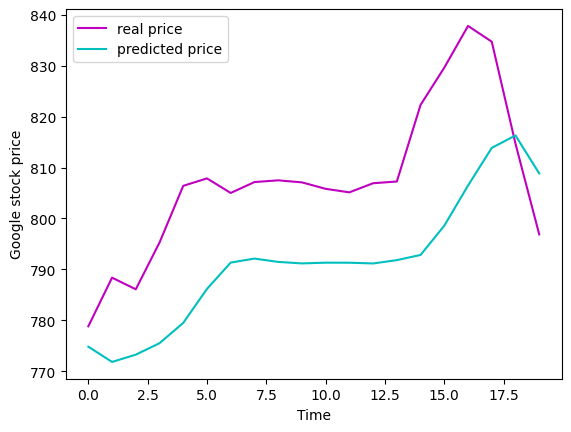

In [9]:
# 예측 및 결과 시각화

df_test_array = df_test.iloc[:, 1:2].values
# 학습셋과 테스트셋 결합
dataset_total = pd.concat( (df_train['Open'], df_test['Open']), axis = 0 )

# 마지막 60일 기간 분리
y_test = dataset_total[len(dataset_total) - len(df_test) - 60:].values

# 데이터를 하나의 열로 가공
y_test = y_test.reshape(-1, 1)

# 테스트셋 정규화 적용
y_test = scaler.transform(y_test)

# 60일 데이터 구조 생성
x_test = []
for i in range(60, 80):
    x_test.append(y_test[i-60:i, 0])
x_test = np.array(x_test)
# 새로운 차원 추가
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# 예측값 산출
predicted_stock_price = RL_model.predict(x_test)

# 정규화된 값을 기존 값으로 재 변환
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)

# 결과값 시각화
plt.plot(df_test_array, color = 'm', label = 'real price')
plt.plot(predicted_stock_price, color = 'c', label = 'predicted price')
plt.xlabel('Time')
plt.ylabel('Google stock price')
plt.legend()
plt.show()